In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
import matplotlib
import matplotlib.pyplot as plt
import smplotlib
from matplotlib import colors
import pandas as pd
import cmasher as cmr
cmap = cmr.dusk

from tqdm import tqdm
import joblib 
import time
import os
import numpy as np
import pickle
from   astropy.table import Table
from   astropy.coordinates import SkyCoord, Galactic, match_coordinates_sky
import astropy.units as u

In [2]:
import smplotlib

def draw_hist2d(ax, true, pred, xrange=[-2, 0.5], 
                C=None, bins=100, cmap='cmr.dusk', text_stats=True, outlier_percent=True,
                out_bound=0.05):
    
    xx = np.linspace(xrange[0], xrange[1])
    res = pred-true
    ax.plot(xx, xx, ls=':', lw=0.5, c='k', zorder=5)
    
    norm = colors.LogNorm(vmin=5)
        
    img = ax.hist2d(true,pred, bins=bins, cmap=cmap, zorder=4, norm=norm)
    ax.set_xlim(xrange);
    ax.set_ylim(xrange);
    
    onesigma_label = 0.5*(np.percentile(res, 86)-np.percentile(res, 14))
    ax.plot(xx, xx+onesigma_label, ls='--', lw=2, c='k', zorder=5)
    ax.plot(xx, xx-onesigma_label, ls='--', lw=2, c='k', zorder=5)
#     yeta = np.sum(np.abs(res)/true > 0.15)/len(res) * 100
    if outlier_percent:
        
        fifteen_bound  = true * 0.15
        
        yeta = np.sum(np.abs(res)>fifteen_bound)/len(res) * 100
    else: 
        
        yeta = np.sum(np.abs(res)>out_bound)/len(res) * 100
    
    
    if text_stats:
        ax.text(0.01, 0.9, "Scatter = %.2f"%(onesigma_label),
                transform=ax.transAxes, zorder=6)
        ax.text(0.01, 0.8, "   Bias   = %.2f"%(np.median(res)),
                transform=ax.transAxes, zorder=6)
        ax.text(0.01, 0.7, f"      $\eta$    = {round(yeta, 2)}%",
                transform=ax.transAxes, zorder=6)
        
    return ax, img, onesigma_label, res, yeta

In [17]:
# data_dir = "/data/jdli/gaia/"
# octable = Table.read(data_dir+"occam_member-DR17.fits")

# df_ocraw = octable.to_pandas()
# print(df_ocraw.shape, df_ocraw.columns)

# df_ocraw = df_ocraw.assign(tmass_id=[i.decode('utf-8') for i in df_ocraw['APOGEE_ID'].values], 
#                            Cluster=[i.decode('utf-8') for i in df_ocraw['CLUSTER'].values])

# df_ocraw = df_ocraw[df_ocraw['FEH_PROB']>0.8]
# print(len(df_ocraw))

# coords_jd     = SkyCoord(l=df['l']*u.degree, b=df['b']*u.degree, frame='galactic')
# coords_occam  = SkyCoord(l=df_ocraw['GLON']*u.degree, b=df_ocraw['GLAT']*u.degree, frame='galactic')

# idx, d2d, d3d = coords_jd.match_to_catalog_sky(coords_occam)


(26699, 17) Index(['CLUSTER', 'APOGEE_ID', 'LOCATION_ID', 'GLON', 'GLAT', 'VHELIO_AVG',
       'VSCATTER', 'FE_H', 'FE_H_ERR', 'PMRA', 'PMRA_ERR', 'PMDEC',
       'PMDEC_ERR', 'RV_PROB', 'FEH_PROB', 'PM_PROB', 'CG_PROB'],
      dtype='object')
2394


In [4]:
occam = pd.read_csv("jdli23_occam.csv")
print(len(occam), occam.columns)

occam = occam[occam['FEH_PROB']>0.8]

occam = occam.dropna(subset=['FE_H', 'FE_H_ERR'])
print(len(occam))

10915 Index(['index', 'teff_xp', 'logg_xp', 'moh_xp', 'aom_xp', 'e_teff_xp',
       'e_logg_xp', 'e_moh_xp', 'e_aom_xp', 'source_id', 'ra', 'dec', 'snr_rp',
       'x_source_id', 'x_ra', 'x_dec', 'l', 'b', 'parallax', 'parallax_error',
       'pmra_1', 'pmra_error', 'pmdec_1', 'pmdec_error', 'ruwe',
       'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp',
       'radial_velocity', 'radial_velocity_error', 'ang_dist', 'CLUSTER',
       'APOGEE_ID', 'LOCATION_ID', 'GLON', 'GLAT', 'VHELIO_AVG', 'VSCATTER',
       'FE_H', 'FE_H_ERR', 'PMRA_2', 'PMRA_ERR', 'PMDEC_2', 'PMDEC_ERR',
       'RV_PROB', 'FEH_PROB', 'PM_PROB', 'CG_PROB', 'Separation'],
      dtype='object')
955


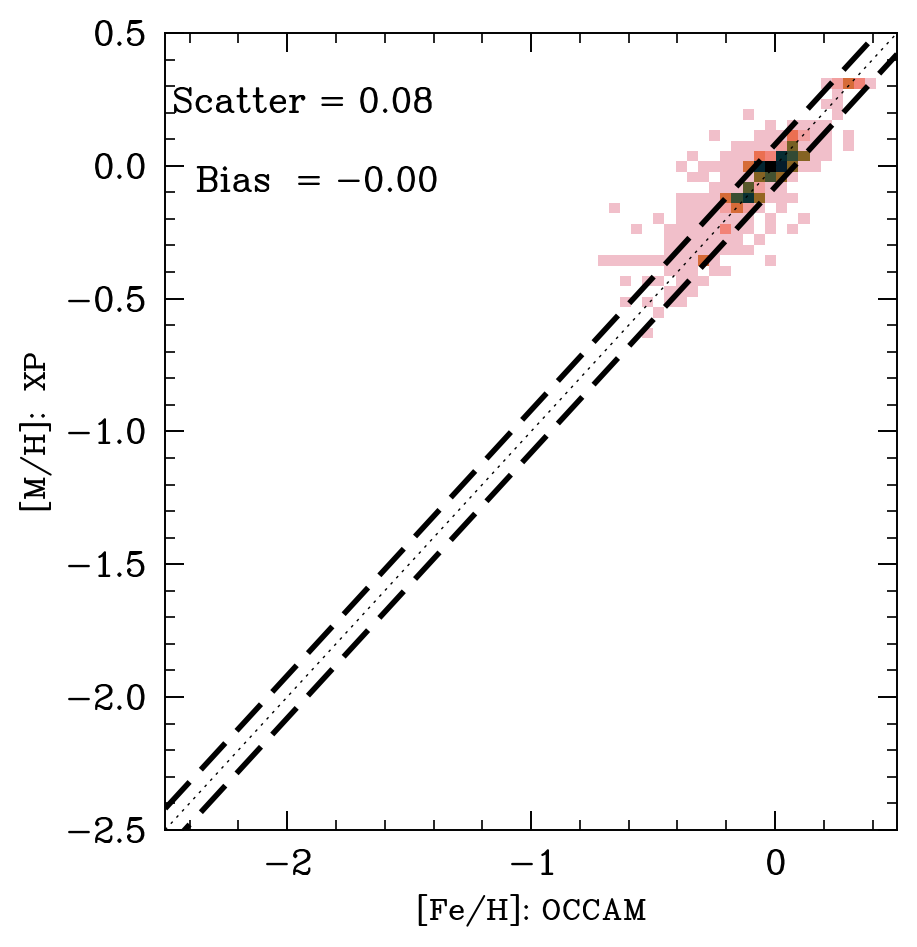

In [93]:
outlier_percents = [True, True, False, False]
text_statss = [False, False, False, False]

xranges = [-2.5, 0.5]
out_bounds = 0.14

fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax, img, onesigma_label, res, yeta = draw_hist2d(
    ax,  occam['moh_xp'].values, occam['FE_H'].values, 
    xrange=xranges, cmap='cmr.dusk_r',
    outlier_percent=out_bounds, bins=25,
    text_stats=False, out_bound=False
)
ax.set_ylabel("[M/H]:  XP", fontsize=13);
ax.set_xlabel("[Fe/H]: OCCAM", fontsize=13);
ax.text(0.01, 0.9, "Scatter = %.2f"%(onesigma_label),
        transform=ax.transAxes, zorder=6)
ax.text(0.01, 0.8, "  Bias  = %.2f"%(np.median(res)),
        transform=ax.transAxes, zorder=6)
        
plt.tight_layout()

In [129]:
moh_xp, e_moh_xp = [], []
feh_ap,  e_feh_c = [], []
Cluster = []
num_member = []


for i, (gn,cluster) in enumerate(occam.groupby('CLUSTER')):
    
    moh_xp.append(cluster['moh_xp'].median())
    e_moh_xp.append(0.5*(np.percentile(cluster['moh_xp'], 86)-\
                         np.percentile(cluster['moh_xp'], 14)))
    feh_ap.append(cluster['FE_H'].median())
    e_feh_c.append(0.5*(np.percentile(cluster['FE_H'], 86)-\
                         np.percentile(cluster['FE_H'], 14)))
    Cluster.append(cluster['CLUSTER'].unique()[0])
    num_member.append(len(cluster))
    
df_cluster = pd.DataFrame(
    data=zip(Cluster, moh_xp, e_moh_xp, feh_ap, e_feh_c, num_member),
    columns=['Cluster', 'moh_xp', 'e_moh_xp', 'feh_ap', 'e_feh_ap', 'num_member']
)   

df_cluster = df_cluster.sort_values(by=['feh_ap'])

In [134]:
df_cluster_5 = df_cluster[df_cluster['num_member']>3]

print(len(df_cluster), len(df_cluster_5))

120 41


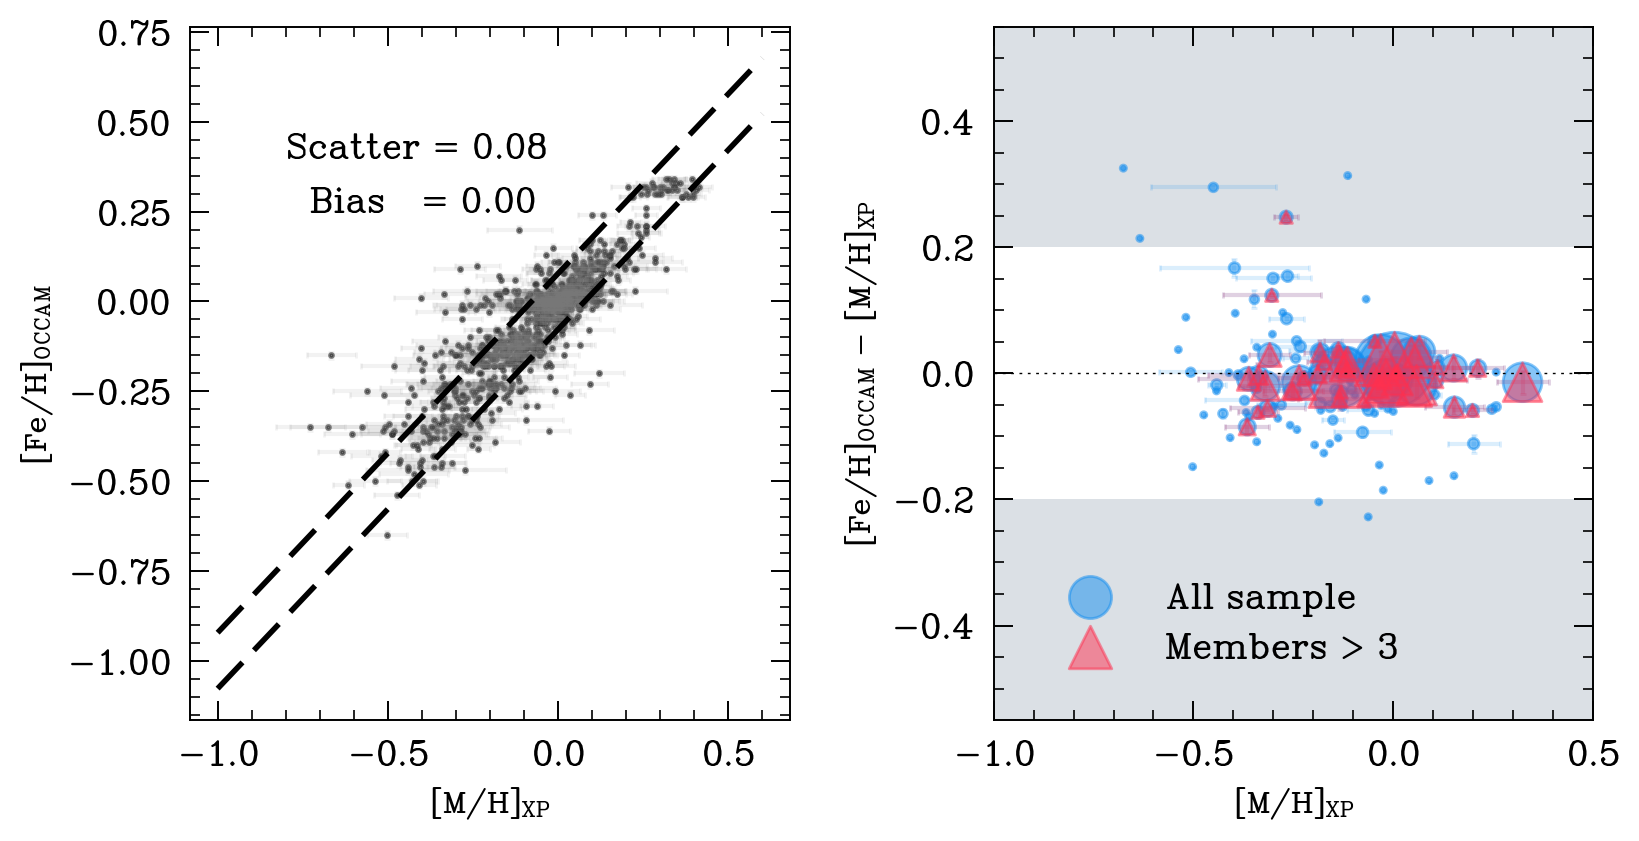

In [136]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8.5, 4.5))

xrange = [-1, 0.6]
xx = np.linspace(xrange[0], xrange[1])

ax1.errorbar(occam['moh_xp'].values, occam['FE_H'].values, 
             xerr=occam['e_moh_xp'].values, yerr=occam['FE_H_ERR'].values, 
             ls="None", c='grey', alpha=0.1, capsize=1)
ax1.scatter(occam['moh_xp'].values, occam['FE_H'].values, 
             c='k', s=2, alpha=0.5)
# ax1, img, onesigma_label, res, yeta = draw_hist2d(
#     ax1,  occam['moh_xp'].values, occam['FE_H'].values, 
#     xrange=xranges, cmap='cmr.dusk_r',
#     outlier_percent=out_bounds, 
#     text_stats=False, out_bound=False
# )
res = occam['moh_xp'].values - occam['FE_H'].values
onesigma_label = 0.5*(np.nanpercentile(res, 86)-np.nanpercentile(res, 14))

ax1.set_xlabel(r"[M/H]$_{\rm XP}$", fontsize=13);
ax1.set_ylabel(r"[Fe/H]$_{\rm OCCAM}$", fontsize=13);
ax1.text(-0.8, 0.4, "Scatter = %.2f"%(onesigma_label), zorder=6)
ax1.text(-0.8, 0.25, "  Bias   = %.2f"%(np.nanmedian(res)), zorder=6)
ax1.plot(xx, xx+onesigma_label, ls='--', lw=2, c='k', zorder=5)
ax1.plot(xx, xx-onesigma_label, ls='--', lw=2, c='k', zorder=5)


color_palatte = ["#118df0", "#ff304f"]

ax2.errorbar(df_cluster['moh_xp'], df_cluster['feh_ap']-df_cluster['moh_xp'], 
            xerr=df_cluster['e_moh_xp'], yerr=df_cluster['e_feh_ap'], 
            capsize=1, alpha=0.15, ls="None", zorder=3, color="#118df0")
ax2.scatter(df_cluster['moh_xp'], df_cluster['feh_ap']-df_cluster['moh_xp'], 
           marker="o",  alpha=0.5, label="All sample",
           s=5*df_cluster['num_member'], zorder=3, color="#118df0")

ax2.errorbar(df_cluster_5['moh_xp'], df_cluster_5['feh_ap']-df_cluster_5['moh_xp'], 
            xerr=df_cluster_5['e_moh_xp'], yerr=df_cluster_5['e_feh_ap'],  
            alpha=0.15, capsize=1, ls="None", zorder=4, color="#ff304f")
ax2.scatter(df_cluster_5['moh_xp'], df_cluster_5['feh_ap']-df_cluster_5['moh_xp'], 
            s=5*df_cluster_5['num_member'], label="Members > 3", 
            alpha=0.5, marker="^", ls="None", zorder=4, color="#ff304f")

ax2.axhspan(0.2,   1, -2, 2, color="#0e2f56", alpha=0.15, lw=0)
ax2.axhspan(-1, -0.2, -2, 2, color="#0e2f56", alpha=0.15, lw=0)

ax2.set_xlabel("Literature [Fe/H]");
ax2.set_xlabel(r"[M/H]$_{\rm XP}$", fontsize=13);
ax2.set_ylabel(r"[Fe/H]$_{\rm OCCAM}$ - [M/H]$_{\rm XP}$", fontsize=13);
ax2.set_xlim([-1., 0.5]);
ax2.set_ylim([-0.55, 0.55]);
ax2.axhline(0, ls=':', lw=0.5, c='k', zorder=5)
ax2.legend(markerscale=0.8);


plt.tight_layout()
fig.savefig("../fig/paper/cluster_compare.pdf")
# fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.95, wspace=0, hspace=0)